In [ ]:
import sys
sys.path.insert(0,"../")

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from torch.utils.data import DataLoader
import torch

In [ ]:
import random
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [ ]:
from core.model.model_node import MoCo_node
from core.dataloader import CLEVR_train, collate_boxes, CLEVR_train_onlyquery, collate_boxes_onlyquery
from core.utils import compute_features
from vis_utils import draw_bounding_box

In [ ]:
kmeans_train_dataset = CLEVR_train_onlyquery(root_dir='/home/mprabhud/dataset/clevr_lang/npys/ab_5v.txt', hyp_N=2)
kmeans_train_loader = DataLoader(kmeans_train_dataset, batch_size=16, shuffle=False, collate_fn=collate_boxes_onlyquery)

query_train_dataset = CLEVR_train(root_dir='/home/mprabhud/dataset/clevr_lang/npys/ab_5v.txt', hyp_N=2)
query_train_loader = DataLoader(query_train_dataset, batch_size=1, shuffle=False, collate_fn=collate_boxes)

Initialised..... 1062  files...
Initialised..... 59  files...


In [ ]:
PATH = "/home/mprabhud/saksham/non-metric_3d_representation/tb_logs/two_obj_node_exp1/checkpoint_99.pth.tar"
state_dict = torch.load(PATH)['state_dict']
r = state_dict['queue'].shape[1]

model = MoCo_node(mode="node", r=r)
model = model.cuda()

model.load_state_dict(state_dict)

<All keys matched successfully>

In [ ]:
# for i, (feed_dict_q, feed_dict_k, metadata) in enumerate((query_train_loader)):
#     break

In [ ]:
from attrdict import AttrDict

args = AttrDict({
    'mode':"node",
    'hyp_N':2
})

In [ ]:
args.mode

'node'

In [ ]:
from vis_utils import store_to_pool_e, DoublePool_O
from tqdm import tqdm

pool_size = 130
pool_e = DoublePool_O(pool_size)
pool_g = DoublePool_O(pool_size)


def store_to_pool(eval_loader, model, args):
    print('Storing to pool...')
    model.eval()
    for i, (feed_dict_q, feed_dict_k, metadata) in enumerate(tqdm(eval_loader)):
        with torch.no_grad():
            q_idx = metadata["query_image_index"].item()
            k_idx = metadata["key_image_index"].item()
            scene_num = metadata["scene_number"].item()
            store_to_pool_e(pool_e, feed_dict_q, metadata, model, args, scene_num, q_idx)
            store_to_pool_e(pool_g, feed_dict_k, metadata, model, args, scene_num, k_idx)
    return


In [ ]:
store_to_pool(query_train_loader, model, args)

  3%|▎         | 2/59 [00:00<00:03, 14.74it/s]

Storing to pool...


100%|██████████| 59/59 [00:03<00:00, 15.85it/s]


In [ ]:
print(pool_e.num)
print(pool_g.num)

118
118


In [ ]:
from sklearn.neighbors import NearestNeighbors
def random_retrieve_topk(args, pool_e, pool_g, imgs_to_view=3):
    print("Fitting k-nearest-neighbour model on pool g...")
    knn = NearestNeighbors(n_neighbors=10, metric="cosine")
    knn.fit(torch.stack(pool_g.embeds).cpu())
    
    random.seed(0)
    
    # select imgs_to_view images from pool q randomly
    query_indices_to_use = random.sample(range(0, pool_e.num), imgs_to_view)
#     print(query_indices_to_use)
    print(len(query_indices_to_use))
    # Perform image retrieval on test images
    print("Performing image retrieval on test images...")
    figures_gen = []
    
    for i, index in enumerate(query_indices_to_use):
        distances, indices = knn.kneighbors(torch.reshape(pool_e.embeds[index], (1,-1)).cpu()) # find k nearest train neighbours
#         print(pool_e.scene_num[index])
        temp = []
        img_query = pool_e.images[index].permute(1,2,0).cpu() # query image        
        temp.append(img_query)
        
        imgs_retrieval = [pool_g.images[idx].permute(1,2,0).cpu() for idx in indices.flatten()]# retrieval images
        temp.extend(imgs_retrieval)
        
        imgs_sub_boxes = [pool_e.sub_box[index]]
        imgs_sub_boxes.extend([pool_g.sub_box[idx] for idx in indices.flatten()])
        
        imgs_obj_boxes = None
        
        scene_nums=[pool_e.scene_num[index]]
        scene_nums.extend([pool_g.scene_num[idx] for idx in indices.flatten()])
        
        view_nums = [pool_e.view_num[index]]
        view_nums.extend([pool_g.view_num[idx] for idx in indices.flatten()])
        
        figures_gen.append([temp, imgs_sub_boxes, imgs_obj_boxes, distances[0],scene_nums, view_nums])
        
    fig = plot_query_retrieval(figures_gen, None, args)
    
    return figures_gen
        

In [ ]:
def plot_query_retrieval(imgs_retrieval, outFile, args):
#     st()
    n_retrieval = len(imgs_retrieval)
    fig = plt.figure(figsize=(20, 2*n_retrieval))
    for idx in range(n_retrieval):
        for im in range(0, 11):
            img = imgs_retrieval[idx][0][im]
            img = img*255
            img = np.array(img,np.int32)
            ax = fig.add_subplot(n_retrieval, 11, 11*idx+im+1,xticks=[], yticks=[])
            if args.mode=='node':
                im_to_plot = draw_bounding_box(img, imgs_retrieval[idx][1][im], None)
            else:
                im_to_plot = draw_bounding_box(img, imgs_retrieval[idx][1][im], imgs_retrieval[idx][2][im])
                if im>1:
                    ax.set_title('S:{}, V:{}'.format(imgs_retrieval[idx][-2][im], imgs_retrieval[idx][-1][im]))
                elif im==0:          
                    ax.set_title('S:{}, V:{}'.format(imgs_retrieval[idx][-2][im], imgs_retrieval[idx][-1][im]))
                else:
                    ax.set_title('S:{}, V:{}'.format(imgs_retrieval[idx][-2][im], imgs_retrieval[idx][-1][im]))
            ax.imshow((im_to_plot))
    plt.show()
    plt.close(fig)
    return fig

Fitting k-nearest-neighbour model on pool g...
10
Performing image retrieval on test images...


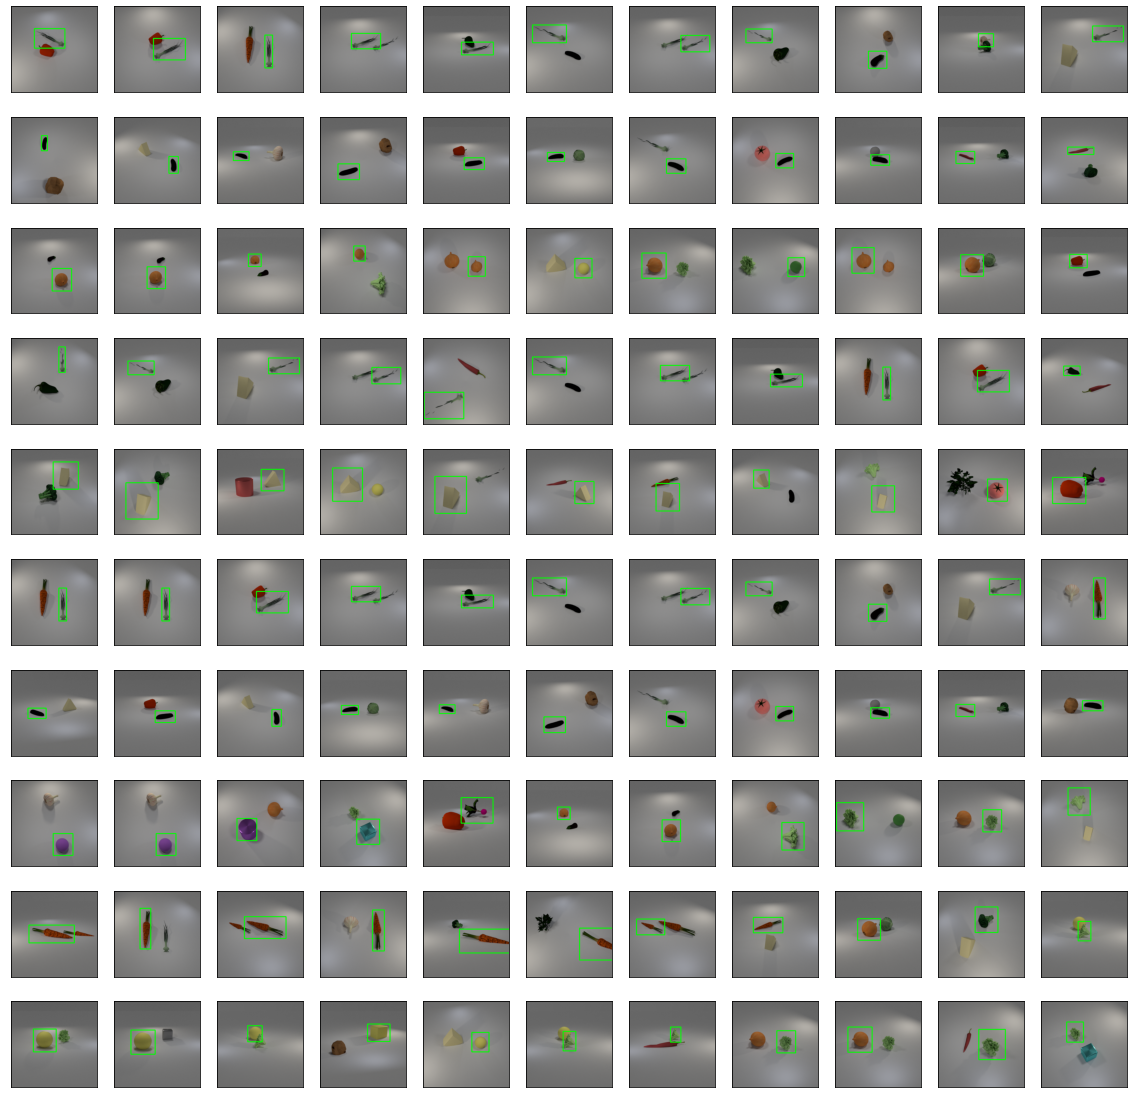

In [ ]:
f = random_retrieve_topk(args, pool_e, pool_g, imgs_to_view=10)
plt.show()

Fitting k-nearest-neighbour model on pool g...
10
Performing image retrieval on test images...


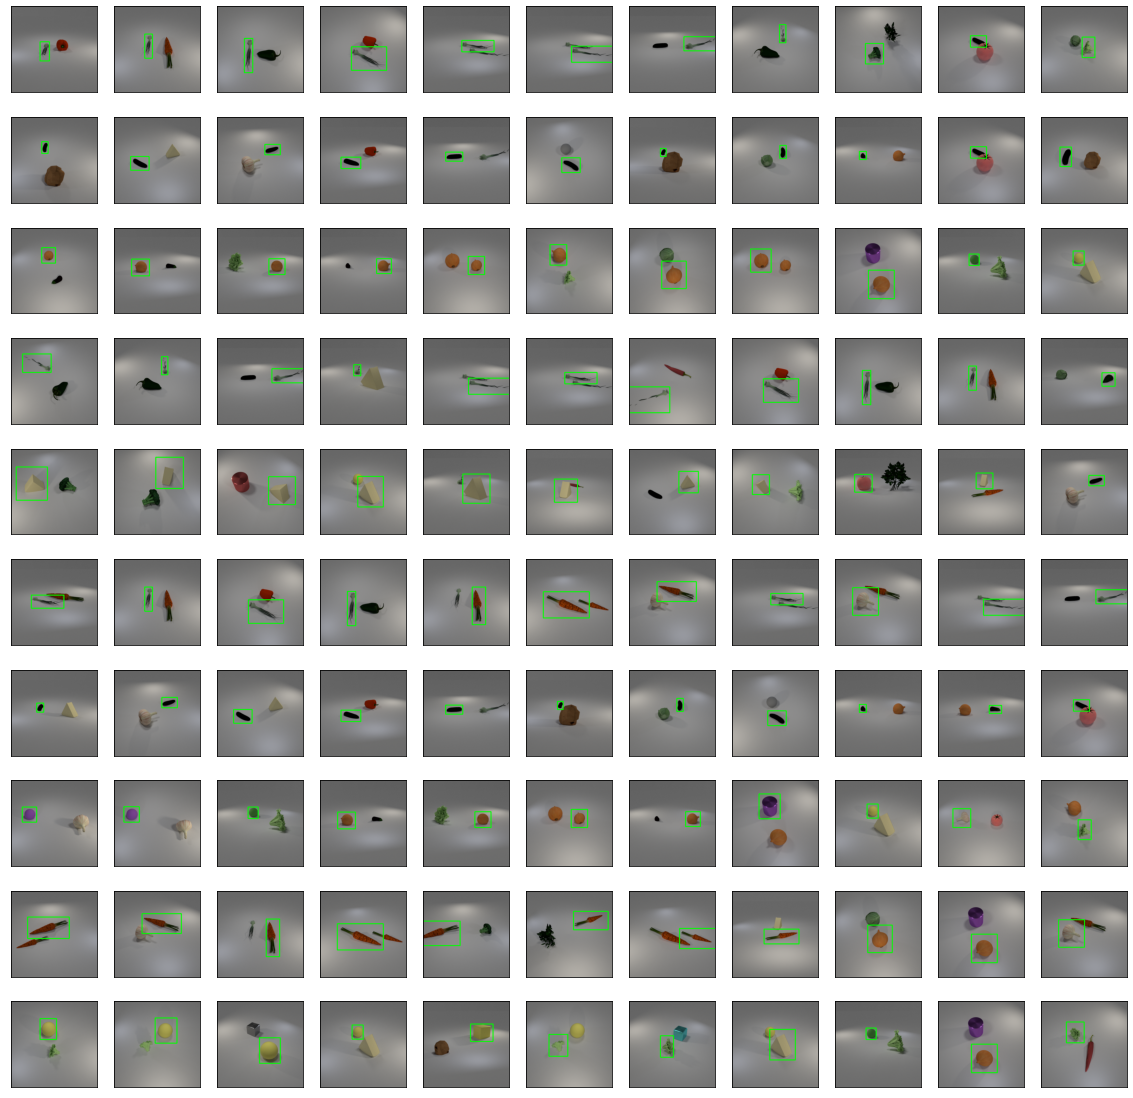

In [ ]:
f = random_retrieve_topk(args, pool_e, pool_g, imgs_to_view=10)
plt.show()

In [ ]:
from sklearn.neighbors import NearestNeighbors
def random_retrieve_topk(pool_e, pool_g, imgs_to_view=3):
    print("==> Fitting k-nearest-neighbour model on pool g...")
    knn = NearestNeighbors(n_neighbors=10, metric="cosine")
    knn.fit(torch.stack(pool_g.embeds).cpu())
    
    # select imgs_to_view images from pool q randomly
    query_indices_to_use = random.sample(range(0, pool_e.num), imgs_to_view)
    
    
    figures_gen = []
    print(query_indices_to_use)

    # Perform image retrieval on test images
    print("==> Performing image retrieval on test images...")
    for i, index in enumerate(query_indices_to_use):
        temp = []
        _, indices = knn.kneighbors(torch.reshape(pool_e.embeds[index], (1,-1)).cpu()) # find k nearest train neighbours
        #print(pool_e.scene_nums[index])
        img_query = pool_e.images[index].permute(1,2,0).cpu() # query image
        temp.append(img_query)
        imgs_retrieval = [pool_g.images[idx].permute(1,2,0).cpu() for idx in indices.flatten()]# retrieval images
        temp.extend(imgs_retrieval)
        #print([pool_g.scene_nums[idx].cpu() for idx in indices.flatten()])
        figures_gen.append(temp)
    fig = plot_query_retrieval(figures_gen, None)
        
    return fig
        

def plot_query_retrieval(imgs_retrieval, outFile):
    n_retrieval = len(imgs_retrieval)
    fig = plt.figure(figsize=(20, 4))
    for idx in range(3):
        for im in range(0, 11):
            ax = fig.add_subplot(3, 11, 11*idx+im+1,xticks=[], yticks=[])
            ax.imshow(imgs_retrieval[idx][im])
            if im==0:
                ax.set_title('Query')
            else:
                ax.set_title('Top_'+str(im))
    #plt.close(fig)
    return fig

==> Fitting k-nearest-neighbour model on pool g...
[29, 15, 5]
==> Performing image retrieval on test images...


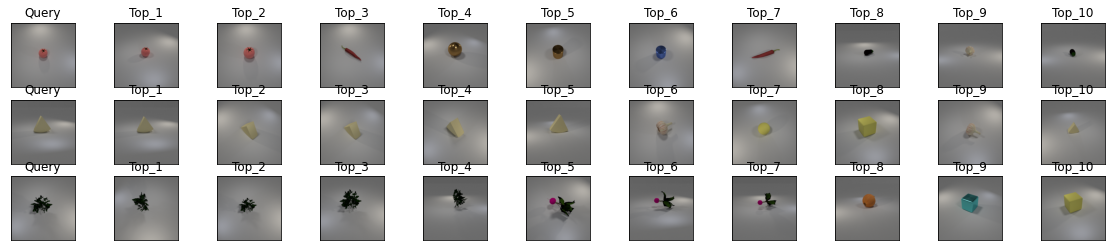

In [ ]:
_ = random_retrieve_topk(pool_e, pool_g, 3)